In [0]:
# upgrade tables bo read_hdf wymaga zaraz
!pip install --upgrade tables
!pip install eli5

In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
#import seaborn as sns

from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import cross_val_score

import eli5
from eli5.sklearn import PermutationImportance

## wczytywanie danych

In [0]:
ls "/content/drive/My Drive/Colab Notebooks/dw_matrix/matrix_two/dw_matrix_car"

data/       day2_visualisation.ipynb  LICENSE
day1.ipynb  day3_first_model.ipynb    README.md


In [0]:
cd "/content/drive/My Drive/Colab Notebooks/dw_matrix/matrix_two/dw_matrix_car/data"

/content/drive/My Drive/Colab Notebooks/dw_matrix/matrix_two/dw_matrix_car/data


In [0]:
ls

car.h5


In [0]:
df = pd.read_hdf('car.h5')
df.shape

(106494, 155)

In [0]:
df.columns

Index(['breadcrumb', 'created_at', 'price_currency', 'price_details',
       'price_value', 'seller_address', 'seller_name', 'seller_type',
       'feature_czujniki-parkowania-przednie',
       'feature_poduszka-powietrzna-chroniąca-kolana',
       ...
       'param_pearl', 'param_stan', 'param_wersja', 'param_emisja-co2',
       'param_body-type', 'param_matowy', 'param_bezwypadkowy',
       'param_akryl-(niemetalizowany)', 'param_monthly-payment-value',
       'car_id'],
      dtype='object', length=155)

Dummy Model

In [0]:
df.select_dtypes(np.number).columns

Index(['price_value', 'car_id'], dtype='object')

In [0]:
features = ['car_id']
X = df[features].values
y = df['price_value'].values

model = DummyRegressor()  # model po prostu liczy średnią
model.fit(X,y)
y_pred = model.predict(X)

mae(y, y_pred)

39465.934630440985

In [0]:
[x for x in df.columns if 'price' in x]

['price_currency', 'price_details', 'price_value']

In [0]:
df['price_currency'].value_counts()

PLN    106290
EUR       204
Name: price_currency, dtype: int64

In [0]:
df['price_currency'].value_counts(normalize=True)*100

PLN    99.80844
EUR     0.19156
Name: price_currency, dtype: float64

In [0]:
df = df[ df['price_currency'] != 'EUR' ]
df.shape

(106290, 155)

## features

In [0]:
df.head()

,breadcrumb,created_at,price_currency,price_details,price_value,seller_address,seller_name,seller_type,feature_czujniki-parkowania-przednie,feature_poduszka-powietrzna-chroniąca-kolana,feature_kurtyny-powietrzne,feature_klimatyzacja-dwustrefowa,feature_światła-led,feature_czujnik-zmierzchu,feature_elektrycznie-ustawiane-lusterka,feature_asr-(kontrola-trakcji),feature_poduszka-powietrzna-kierowcy,feature_cd,feature_elektryczne-szyby-przednie,feature_poduszka-powietrzna-pasażera,feature_system-start-stop,feature_światła-do-jazdy-dziennej,feature_komputer-pokładowy,feature_elektryczne-szyby-tylne,feature_klimatyzacja-manualna,feature_tapicerka-welurowa,feature_czujnik-deszczu,feature_światła-przeciwmgielne,feature_ogrzewanie-postojowe,feature_radio-niefabryczne,feature_regulowane-zawieszenie,feature_ogranicznik-prędkości,feature_zmieniarka-cd,feature_szyberdach,feature_isofix,feature_asystent-pasa-ruchu,feature_alufelgi,feature_bluetooth,feature_nawigacja-gps,feature_asystent-parkowania,...,param_particle-filter,param_zarejestrowany-w-polsce,param_oferta-od,param_moc,param_make,param_kraj-pochodzenia,param_engine-power,param_year,param_serwisowany-w-aso,param_rodzaj-paliwa,param_możliwość-finansowania,param_registered-in-poland,param_transmission,param_miesięczna-rata,param_kod-silnika,param_version,param_opłata-początkowa,param_model-pojazdu,param_pojemność-skokowa,param_kierownica-po-prawej-(anglik),param_fuel-type,param_vat-free,param_acrylic,param_damaged,param_door-count,param_tuning,param_filtr-cząstek-stałych,param_nr-of-seats,param_kolor,param_engine-capacity,param_pearl,param_stan,param_wersja,param_emisja-co2,param_body-type,param_matowy,param_bezwypadkowy,param_akryl-(niemetalizowany),param_monthly-payment-value,car_id
0,"[Osobowe, Dacia, Logan, Dacia Logan II (2012-)]","13:23, 5 marca 2018",PLN,Cena Brutto,45100.0,"Krasne 7A - 36-007 Krasne, rzeszowski, Podkarp...",AUTO SPEKTRUM,Dealer,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,True,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,...,None,None,Firmy,90 KM,None,None,None,None,None,Benzyna+LPG,None,None,None,None,None,None,None,Logan,898 cm3,None,None,None,None,None,None,None,None,None,Inny kolor,None,None,Nowe,II (2012-),None,None,None,Tak,None,None,0
2,"[Osobowe, Peugeot, 3008, Peugeot 3008 I (2009-...","15:48, 5 marca 2018",PLN,"Cena Brutto, Do negocjacji, Faktura VAT",28000.0,"Tomaszów Mazowiecki, tomaszowski, Łódzkie",None,Osoba prywatna,False,False,False,True,False,False,True,True,True,True,True,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,...,None,Tak,Osoby prywatnej,115 KM,None,Polska,None,None,None,Diesel,None,None,None,None,None,None,None,3008,1 560 cm3,None,None,None,None,None,None,None,None,None,Czarny,None,None,Używane,I (2009-2016),None,None,None,Tak,None,None,2
3,"[Osobowe, Porsche, Cayenne, Porsche Cayenne II...","06:30, 4 marca 2018",PLN,"Cena Netto, Do negocjacji, Faktura VAT",229500.0,"Kępińska 24a - 63-640 Bralin, kępiński, Wielko...",P.W. GRIB,Dealer,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,True,True,True,False,True,True,True,True,True,False,True,True,True,True,...,None,None,Firmy,262 KM,None,Niemcy,None,None,Tak,Diesel,Tak,None,None,None,None,None,None,Cayenne,3 000 cm3,None,None,None,None,None,None,None,None,None,Czarny,None,None,Używane,II (2010-),None,None,None,None,None,None,3
4,"[Osobowe, Peugeot, 308, Peugeot 308 T7 (2008-2...","08:46, 3 marca 2018",PLN,"Cena Brutto, Do negocjacji",19500.0,"Limanowa, limanowski, Małopolskie",None,Osoba prywatna,False,False,False,False,False,True,True,True,True,True,True,True,False,False,True,True,False,False,True,True,False,False,False,False,False,False,True,False,True,False,False,False,...,None,Tak,Osoby prywatnej,110 KM,None,Polska,None,None,Tak,Diesel,None,None,None,None,None,None,None,308,1

In [0]:
df['param_color'].factorize()

(array([-1, -1, -1, ..., -1, -1, -1]),
 Index(['Czarny', 'Srebrny', 'Złoty', 'Bordowy', 'Biały', 'Szary', 'Beżowy',
        'Zielony', 'Fioletowy', 'Niebieski', 'Inny kolor', 'Brązowy', 'Żółty'],
       dtype='object'))

In [0]:
SUFFIX_CAT = '__cat'
for feat in df.columns:
  if isinstance(df[feat][0], list): continue
  
  factorized_values = df[feat].factorize()[0]
  if SUFFIX_CAT in feat:
    df[feat] = factorized_values
  else:
    df[feat+SUFFIX_CAT] = factorized_values

In [0]:
cat_feats = [x for x in df.columns if SUFFIX_CAT in x]
# bez cen
cat_feats = [x for x in cat_feats if 'price' not in x]
len(cat_feats)

151

In [0]:
X = df[cat_feats].values
y = df['price_value'].values

model = DecisionTreeRegressor(max_depth=5)
scores = cross_val_score(model, X, y, cv=3, scoring='neg_mean_absolute_error')
np.mean(scores)

-19566.588937368324

In [0]:
m = DecisionTreeRegressor(max_depth=5)
m.fit(X,y)

imp = PermutationImportance(m, random_state = 0).fit(X,y)
eli5.show_weights(imp, feature_names=cat_feats)

Weight,Feature
0.2533 ± 0.0040,param_napęd__cat
0.2008 ± 0.0047,param_faktura-vat__cat
0.1943 ± 0.0088,param_stan__cat
0.1423 ± 0.0086,param_rok-produkcji__cat
0.0629 ± 0.0047,param_moc__cat
0.0424 ± 0.0014,feature_kamera-cofania__cat
0.0412 ± 0.0008,param_skrzynia-biegów__cat
0.0286 ± 0.0037,param_marka-pojazdu__cat
0.0191 ± 0.0022,param_pojemność-skokowa__cat
0.0163 ± 0.0005,feature_bluetooth__cat


## dodaję przebieg przeliczony na przedziały

In [0]:
df['param_przebieg_int'] = df['param_przebieg'].map(lambda x: int(str(x).replace("km","").replace(" ", "")) if x else 0).astype(int)

In [0]:
df['param_przebieg_int'].describe()

count    1.062900e+05
mean     1.441587e+05
std      1.313119e+05
min      0.000000e+00
25%      6.700000e+04
50%      1.540000e+05
75%      2.050000e+05
max      1.460069e+07
Name: param_przebieg_int, dtype: float64

max coś strasznie duży (dziesiąt milionów?)


In [0]:
df[df['param_przebieg_int']==df['param_przebieg_int'].max()][['breadcrumb','price_value','param_marka-pojazdu', 'param_model','param_rok-produkcji','param_przebieg']]

,breadcrumb,price_value,param_marka-pojazdu,param_model,param_rok-produkcji,param_przebieg
10686,"[Osobowe, Renault, Scenic, Renault Scenic II (...",6900.0,Renault,None,2004,14 600 690 km


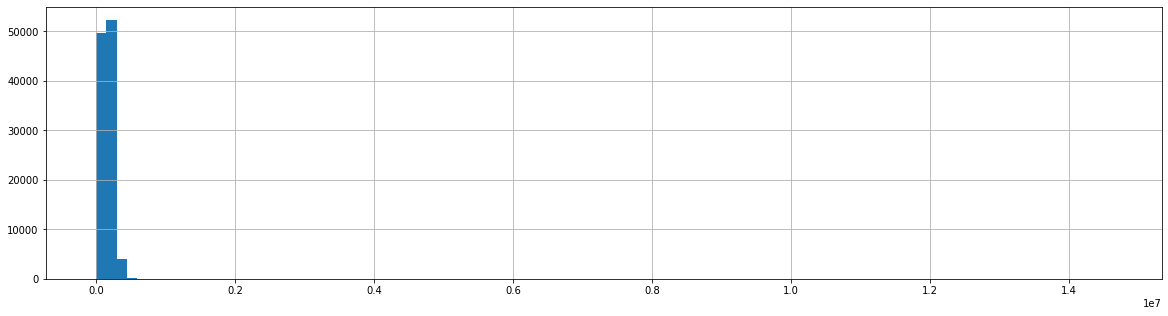

In [0]:
df.param_przebieg_int.hist(bins=100, figsize=(20,5));

odcinam odstające wartości powyżej 1mln

In [0]:
df[df['param_przebieg_int']>1000000][['breadcrumb','price_value','param_marka-pojazdu', 'param_model','param_rok-produkcji','param_przebieg']]

,breadcrumb,price_value,param_marka-pojazdu,param_model,param_rok-produkcji,param_przebieg
1879,"[Osobowe, Jaguar, Inny]",69000.0,Jaguar,None,1990,9 999 999 km
3619,"[Osobowe, Hyundai, I30, Hyundai I30 I (2007-20...",22900.0,Hyundai,None,2011,1 030 000 km
5494,"[Osobowe, Nissan, Patrol, Nissan Patrol GR I Y...",13900.0,Nissan,None,1989,1 111 111 km
7052,"[Osobowe, BMW, Seria 3, 320, BMW Seria 3 E90 (...",24400.0,BMW,None,2006,1 111 111 km
7165,"[Osobowe, Inny, Inny]",50000.0,Inny,None,2014,5 000 000 km
...,...,...,...,...,...,...
153738,"[Osobowe, Ford, Focus C-Max]",10900.0,Ford,None,2002,2 972 987 km
154983,"[Osobowe, Audi, A4, Audi A4 B7 (2004-2007)]",21500.0,Audi,None,2005,1 225 000 km
155920,"[Osobowe, Seat, Toledo, Seat Toledo II (1999-2...",8900.0,Seat,None,2003,2 122 715 km
157541,"[Osobowe, Volvo, V40, Volvo V40 I (1995-2004)]",3700.0,Volvo,None,1999,2 920 000 km


In [0]:
df['param_przebieg_int'] = df['param_przebieg_int'].map(lambda x: x if x < 1000000 else -1)  #do modelu nie może być None, więc daję -1 znaczące brak

In [0]:
df[df['param_przebieg_int']>1000000]

,breadcrumb,created_at,price_currency,price_details,price_value,seller_address,seller_name,seller_type,feature_czujniki-parkowania-przednie,feature_poduszka-powietrzna-chroniąca-kolana,feature_kurtyny-powietrzne,feature_klimatyzacja-dwustrefowa,feature_światła-led,feature_czujnik-zmierzchu,feature_elektrycznie-ustawiane-lusterka,feature_asr-(kontrola-trakcji),feature_poduszka-powietrzna-kierowcy,feature_cd,feature_elektryczne-szyby-przednie,feature_poduszka-powietrzna-pasażera,feature_system-start-stop,feature_światła-do-jazdy-dziennej,feature_komputer-pokładowy,feature_elektryczne-szyby-tylne,feature_klimatyzacja-manualna,feature_tapicerka-welurowa,feature_czujnik-deszczu,feature_światła-przeciwmgielne,feature_ogrzewanie-postojowe,feature_radio-niefabryczne,feature_regulowane-zawieszenie,feature_ogranicznik-prędkości,feature_zmieniarka-cd,feature_szyberdach,feature_isofix,feature_asystent-pasa-ruchu,feature_alufelgi,feature_bluetooth,feature_nawigacja-gps,feature_asystent-parkowania,...,param_oferta-od__cat,param_moc__cat,param_make__cat,param_kraj-pochodzenia__cat,param_engine-power__cat,param_year__cat,param_serwisowany-w-aso__cat,param_rodzaj-paliwa__cat,param_możliwość-finansowania__cat,param_registered-in-poland__cat,param_transmission__cat,param_miesięczna-rata__cat,param_kod-silnika__cat,param_version__cat,param_opłata-początkowa__cat,param_model-pojazdu__cat,param_pojemność-skokowa__cat,param_kierownica-po-prawej-(anglik)__cat,param_fuel-type__cat,param_vat-free__cat,param_acrylic__cat,param_damaged__cat,param_door-count__cat,param_tuning__cat,param_filtr-cząstek-stałych__cat,param_nr-of-seats__cat,param_kolor__cat,param_engine-capacity__cat,param_pearl__cat,param_stan__cat,param_wersja__cat,param_emisja-co2__cat,param_body-type__cat,param_matowy__cat,param_bezwypadkowy__cat,param_akryl-(niemetalizowany)__cat,param_monthly-payment-value__cat,car_id__cat,param_przebieg_int,param_przebieg_bins


teraz wykres wygląda znacznie lepiej

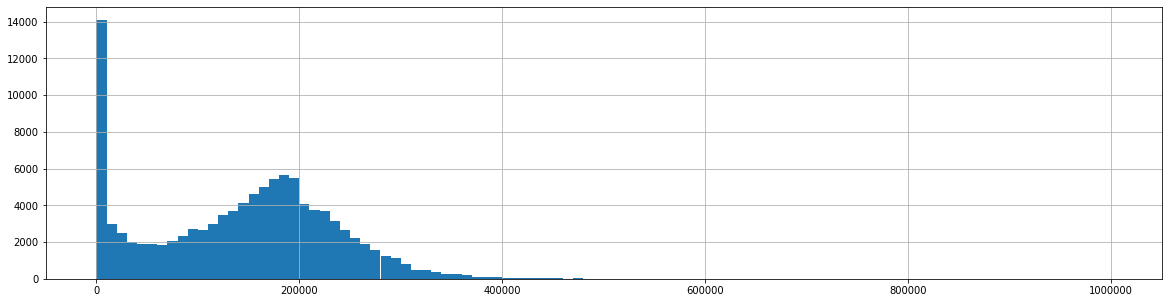

In [0]:
df.param_przebieg_int.hist(bins=100, figsize=(20,5));

jeszcze skubełkowanie (choć po usunięciu odstających, już chyba nie potrzebne, bo ten histogram jest całkime ok)
w zasadzie do wizualizacji się przyda
można się jeszcze zastanowić nad większym usunięciem ogona, ciekawe co da

In [0]:
df['param_przebieg_bins'] = pd.cut(df['param_przebieg_int'],20).map(lambda x: x.right)
# qcut rozcina na równe kawałki ilościowo
# qcut po prostu dzieli oś X

In [0]:
df['param_przebieg_bins'].value_counts()

199999.0    26221
49999.0     23431
249999.0    17290
149999.0    16876
99999.0     10827
299999.0     8086
349999.0     2399
399999.0      776
449999.0      216
499999.0       88
549999.0       32
599999.0       19
999999.0        8
649999.0        6
799999.0        6
699999.0        3
949999.0        2
749999.0        2
899999.0        2
849999.0        0
Name: param_przebieg_bins, dtype: int64

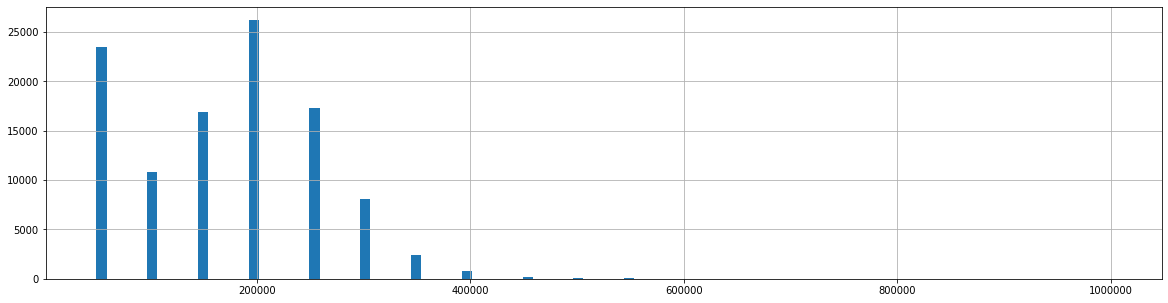

In [0]:
df.param_przebieg_bins.hist(bins=100, figsize=(20,5));

In [0]:
def group_and_barplot(feat_groupby, feat_agg='price_value', agg_funcs=[np.mean, np.median, np.size], feat_sort='mean', ascending=False, top=50, subplots=True, ):
  return(
    df
    .groupby(feat_groupby)[feat_agg]
    .agg(agg_funcs)
    .sort_values(by=feat_sort, ascending=ascending)
    .head(top)
  ).plot(kind='bar', figsize=(20,5), subplots=subplots)

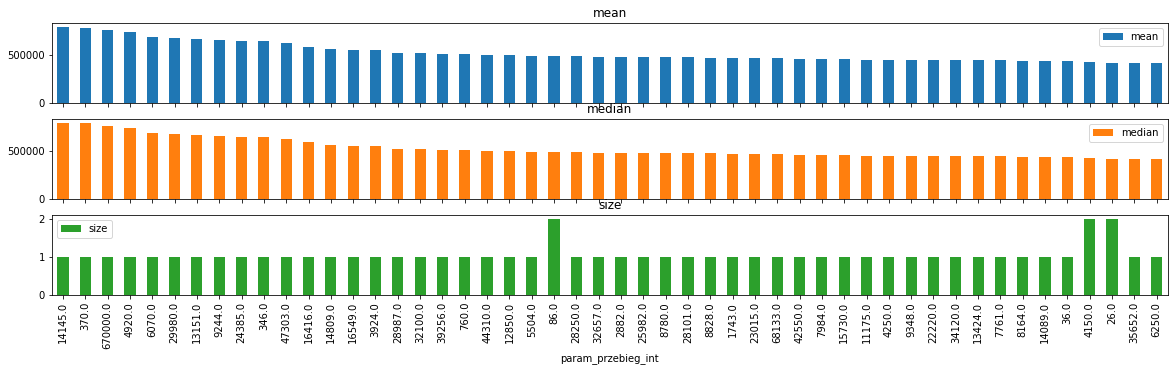

In [145]:
group_and_barplot('param_przebieg_int');

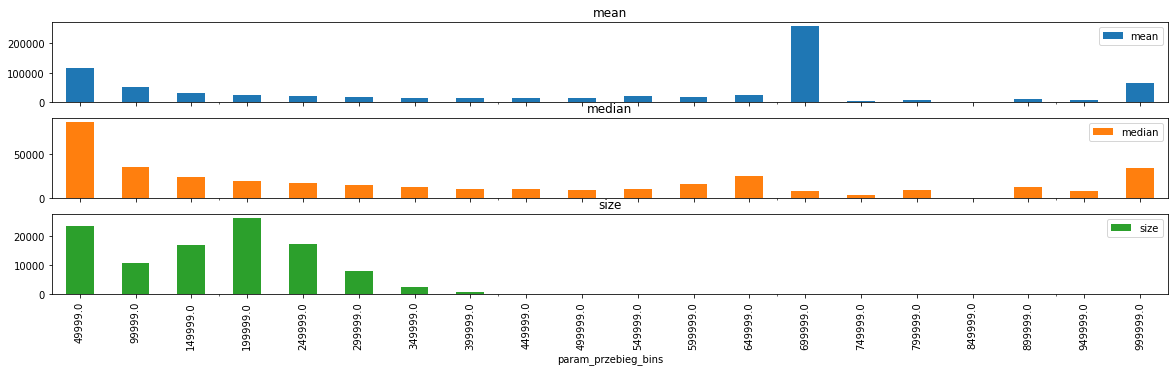

In [142]:
group_and_barplot('param_przebieg_bins', feat_sort='param_przebieg_bins', ascending=True);

dorzucam nowe kolumny do features

In [0]:
cat_feats += ['param_przebieg_bins', 'param_przebieg_int']
len(cat_feats)

153

## ponowne sprawdzenie które feats wpływają na wynik

In [136]:
X = df[cat_feats].values
y = df['price_value'].values

model = DecisionTreeRegressor(max_depth=5)
scores = cross_val_score(model, X, y, cv=3, scoring='neg_mean_absolute_error')
np.mean(scores)

-17780.563379701005

In [0]:
m = DecisionTreeRegressor(max_depth=5)
m.fit(X,y)

imp = PermutationImportance(m, random_state = 0).fit(X,y)
eli5.show_weights(imp, feature_names=cat_feats)

Weight,Feature
0.6232 ± 0.0103,param_przebieg_int
0.3212 ± 0.0099,param_napęd__cat
0.0490 ± 0.0032,param_moc__cat
0.0328 ± 0.0018,feature_kamera-cofania__cat
0.0316 ± 0.0010,param_skrzynia-biegów__cat
0.0276 ± 0.0012,param_wersja__cat
0.0243 ± 0.0008,feature_regulowane-zawieszenie__cat
0.0218 ± 0.0002,param_rok-produkcji__cat
0.0202 ± 0.0034,param_marka-pojazdu__cat
0.0177 ± 0.0010,feature_bluetooth__cat
